In [1]:
import yfinance as yf
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandasgui import show
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow import keras
from sklearn.preprocessing import Normalizer

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
dfImputado = pd.read_csv('informacionCompaniasImputado.csv')

In [5]:
nombres = dfImputado[['symbol']]
marketCap = dfImputado[['marketCap']]
logMarketCap = np.log2(marketCap)
minMarketCap = marketCap.min()
normalizedMarketCap = (marketCap - minMarketCap)
newMaxMarkCap = normalizedMarketCap.max()
normalizedMarketCap = normalizedMarketCap/newMaxMarkCap * 1000
dfImputadoX =dfImputado.drop(['symbol', 'marketCap', 'Unnamed: 0', 'Unnamed: 0.1', 'priceHint' ], axis=1)

In [6]:
dfImputadoX

,fullTimeEmployees,auditRisk,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk,exDividendDate,payoutRatio,beta,forwardPE,...,returnOnAssets,returnOnEquity,grossProfits,freeCashflow,operatingCashflow,earningsGrowth,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins
0,92000.0,8.0,7.0,5.0,4.0,6.0,1.684368e+09,0.6167,0.948979,10.892136,...,0.06742,0.360340,1.500000e+10,3.498250e+09,5.855000e+09,-0.221,-0.090,0.42547,0.20460,0.14962
1,12000.0,2.0,10.0,7.0,10.0,10.0,1.682554e+09,0.7296,1.262843,18.018919,...,0.12177,0.134920,1.329600e+09,3.090125e+08,4.948000e+08,0.105,-0.012,0.36394,0.19649,0.17624
2,115000.0,8.0,9.0,9.0,2.0,8.0,1.681344e+09,0.5836,0.662913,22.266235,...,0.06318,0.159320,2.457900e+10,6.409875e+09,8.659000e+09,-0.453,-0.181,0.55639,0.25831,0.18000
3,50000.0,9.0,7.0,7.0,9.0,9.0,1.681344e+09,1.3435,0.551020,13.355339,...,0.09443,0.512750,4.152700e+10,2.160288e+10,2.422800e+10,-0.949,-0.097,0.70959,0.52031,0.36979
4,738000.0,1.0,3.0,4.0,4.0,1.0,1.681258e+09,0.3849,1.241731,24.133547,...,0.13110,0.309490,1.970154e+10,8.329611e+09,9.680274e+09,-0.059,0.051,0.32120,0.16945,0.15288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,36000.0,1.0,2.0,10.0,7.0,8.0,1.685059e+09,0.5434,1.000703,21.972927,...,0.23843,0.632544,3.307000e+09,7.075000e+08,1.523000e+09,-0.228,0.063,0.48501,0.33775,0.31787
489,10500.0,1.0,9.0,8.0,9.0,8.0,1.655090e+09,0.0000,1.666080,14.561056,...,0.08776,0.140760,2.624000e+09,7.526250e+08,3.580000e+08,-0.243,-0.019,0.46124,0.20003,0.16597
490,18000.0,2.0,8.0,10.0,4.0,8.0,1.687478e+09,0.4486,1.004222,16.056604,...,0.04118,0.037280,4.920400e+09,1.391900e+09,1.355200e+09,15.353,0.101,0.71576,0.32870,0.19864
491,10064.0,3.0,5.0,5.0,5.0,4.0,1.684282e+09,0.2752,1.100985,5.586744,...,0.01010,0.158220,3.030000e+09,5.556691e+08,1.403000e+09,0.047,0.104,0.00000,0.00000,0.39581


In [7]:
dfImputadoXNormalizado=(dfImputadoX-dfImputadoX.mean())/dfImputadoX.std()


In [8]:
dfImputadoXNormalizado

,fullTimeEmployees,auditRisk,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk,exDividendDate,payoutRatio,beta,forwardPE,...,returnOnAssets,returnOnEquity,grossProfits,freeCashflow,operatingCashflow,earningsGrowth,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins
0,0.251572,0.908165,0.518166,-0.151197,-0.502385,0.180484,0.212697,-0.022770,-0.257709,-0.562983,...,-0.017174,0.002701,0.130035,0.120825,0.047555,-0.213124,-0.635000,-0.013497,-0.260052,-0.379124
1,-0.324154,-1.211429,1.572041,0.554809,1.585327,1.580011,0.194140,-0.005064,0.484265,-0.066964,...,0.959102,-0.123876,-0.454522,-0.324755,-0.432795,-0.090146,-0.345242,-0.280726,-0.307053,-0.183598
2,0.417093,0.908165,1.220749,1.260815,-1.198288,0.880248,0.181769,-0.027961,-0.933968,0.228646,...,-0.093337,-0.110175,0.539640,0.527618,0.298833,-0.300642,-0.973052,0.555099,0.051218,-0.155981
3,-0.050684,1.261431,0.518166,0.554809,1.237375,1.230129,0.181769,0.091215,-1.198483,-0.391546,...,0.468000,0.088281,1.264350,2.650285,1.694038,-0.487750,-0.661004,1.220458,1.569611,1.238035
4,4.900556,-1.564695,-0.887001,-0.504200,-0.502385,-1.568926,0.180885,-0.059124,0.434357,0.358609,...,1.126694,-0.025853,0.331076,0.795831,0.390354,-0.152012,-0.111206,-0.466349,-0.463760,-0.355179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,-0.151436,-1.564695,-1.238292,1.613819,0.541471,0.880248,0.219767,-0.034266,-0.135433,0.208232,...,3.054638,0.155547,-0.369967,-0.269080,-0.340654,-0.215765,-0.066628,0.245090,0.511604,0.856681
489,-0.334949,-1.564695,1.220749,0.907812,1.237375,0.880248,-0.086754,-0.119488,1.437517,-0.307629,...,0.348188,-0.120597,-0.399172,-0.262776,-0.445055,-0.221423,-0.371246,0.141855,-0.286537,-0.259032
490,-0.280974,-1.211429,0.869457,1.613819,-0.502385,0.880248,0.244510,-0.049133,-0.127114,-0.203540,...,-0.488517,-0.178703,-0.300976,-0.173461,-0.355691,5.661907,0.074537,1.247254,0.459156,-0.019069
491,-0.338086,-0.858164,-0.184417,-0.151197,-0.154433,-0.519280,0.211814,-0.076328,0.101633,-0.932234,...,-1.046800,-0.110793,-0.381811,-0.290293,-0.351408,-0.112026,0.085681,-1.861345,-1.445789,1.429153


In [9]:
X_train, X_test, y_train, y_test = train_test_split(dfImputadoXNormalizado, normalizedMarketCap, test_size=0.2, random_state=42)

In [32]:
modelo = keras.Sequential(
    [keras.layers.Dense(81, activation = "relu"), #Para el input 81 neuronas
    keras.layers.Dense(20, activation = "relu"), 
    keras.layers.Dense(10, activation = "relu"), 
    keras.layers.Dense(5, activation = "relu"), 
    keras.layers.Dense(3, activation = "relu"), 
    keras.layers.Dense(1, activation = "relu")] #Para el output una sola neurona
)

In [33]:
modelo.compile(loss="mape", metrics=["mae", "mse"], optimizer="adam")

In [34]:
historial = modelo.fit(dfImputadoXNormalizado, normalizedMarketCap,epochs=500)

Epoch 1/500
16/16 [==============================] - 1s 3ms/step - loss: 214428.3281 - mae: 26.5958 - mse: 6848.4438
Epoch 2/500
16/16 [==============================] - 0s 2ms/step - loss: 130.4375 - mae: 26.5679 - mse: 6845.8511
Epoch 3/500
16/16 [==============================] - 0s 2ms/step - loss: 97.9570 - mae: 26.5229 - mse: 6841.4053
Epoch 4/500
16/16 [==============================] - 0s 2ms/step - loss: 293853.0000 - mae: 26.3666 - mse: 6832.6855
Epoch 5/500
16/16 [==============================] - 0s 2ms/step - loss: 89.5191 - mae: 25.9766 - mse: 6819.1621
Epoch 6/500
16/16 [==============================] - 0s 3ms/step - loss: 78.1112 - mae: 25.2261 - mse: 6789.9258
Epoch 7/500
16/16 [==============================] - 0s 3ms/step - loss: 70.7688 - mae: 24.3696 - mse: 6750.9463
Epoch 8/500
16/16 [==============================] - 0s 3ms/step - loss: 68.6730 - mae: 23.9599 - mse: 6715.1182
Epoch 9/500
16/16 [==============================] - 0s 3ms/step - loss: 66.5146 - mae:

Epoch 73/500
16/16 [==============================] - 0s 3ms/step - loss: 15.8546 - mae: 9.3749 - mse: 2168.5503
Epoch 74/500
16/16 [==============================] - 0s 3ms/step - loss: 15.3334 - mae: 9.3536 - mse: 2195.3552
Epoch 75/500
16/16 [==============================] - 0s 3ms/step - loss: 15.4844 - mae: 9.3395 - mse: 2187.9106
Epoch 76/500
16/16 [==============================] - 0s 3ms/step - loss: 15.3962 - mae: 9.2707 - mse: 2155.7371
Epoch 77/500
16/16 [==============================] - 0s 3ms/step - loss: 15.2572 - mae: 9.2368 - mse: 2140.8538
Epoch 78/500
16/16 [==============================] - 0s 2ms/step - loss: 14.9854 - mae: 9.2014 - mse: 2134.8264
Epoch 79/500
16/16 [==============================] - 0s 2ms/step - loss: 14.9234 - mae: 9.0548 - mse: 2056.9016
Epoch 80/500
16/16 [==============================] - 0s 2ms/step - loss: 14.5073 - mae: 9.0045 - mse: 2046.7612
Epoch 81/500
16/16 [==============================] - 0s 3ms/step - loss: 14.2549 - mae: 8.9401 

16/16 [==============================] - 0s 4ms/step - loss: 9.3362 - mae: 6.2507 - mse: 1039.7811
Epoch 146/500
16/16 [==============================] - 0s 2ms/step - loss: 8.8171 - mae: 6.1361 - mse: 1007.7758
Epoch 147/500
16/16 [==============================] - 0s 2ms/step - loss: 8.9659 - mae: 6.1027 - mse: 997.8925
Epoch 148/500
16/16 [==============================] - 0s 3ms/step - loss: 8.8944 - mae: 6.0254 - mse: 972.9503
Epoch 149/500
16/16 [==============================] - 0s 2ms/step - loss: 8.6104 - mae: 6.0556 - mse: 985.0767
Epoch 150/500
16/16 [==============================] - 0s 4ms/step - loss: 8.5570 - mae: 5.9755 - mse: 960.7934
Epoch 151/500
16/16 [==============================] - 0s 3ms/step - loss: 8.5600 - mae: 5.9238 - mse: 940.8895
Epoch 152/500
16/16 [==============================] - 0s 2ms/step - loss: 8.8207 - mae: 5.9376 - mse: 945.5040
Epoch 153/500
16/16 [==============================] - 0s 3ms/step - loss: 8.5707 - mae: 5.9576 - mse: 959.7168
Epoc

16/16 [==============================] - 0s 3ms/step - loss: 6.5166 - mae: 4.6119 - mse: 618.9019
Epoch 219/500
16/16 [==============================] - 0s 3ms/step - loss: 6.1717 - mae: 4.4960 - mse: 587.1573
Epoch 220/500
16/16 [==============================] - 0s 3ms/step - loss: 6.2577 - mae: 4.5356 - mse: 598.6981
Epoch 221/500
16/16 [==============================] - 0s 3ms/step - loss: 5.8363 - mae: 4.4370 - mse: 586.4122
Epoch 222/500
16/16 [==============================] - 0s 2ms/step - loss: 6.0511 - mae: 4.4700 - mse: 585.9238
Epoch 223/500
16/16 [==============================] - 0s 1ms/step - loss: 5.5661 - mae: 4.4124 - mse: 581.8531
Epoch 224/500
16/16 [==============================] - 0s 2ms/step - loss: 5.7116 - mae: 4.3825 - mse: 571.0476
Epoch 225/500
16/16 [==============================] - 0s 2ms/step - loss: 5.7228 - mae: 4.3940 - mse: 566.1688
Epoch 226/500
16/16 [==============================] - 0s 2ms/step - loss: 5.9773 - mae: 4.4346 - mse: 578.0901
Epoch 

16/16 [==============================] - 0s 3ms/step - loss: 4.3484 - mae: 3.5361 - mse: 416.7921
Epoch 292/500
16/16 [==============================] - 0s 3ms/step - loss: 4.5296 - mae: 3.4472 - mse: 389.6960
Epoch 293/500
16/16 [==============================] - 0s 3ms/step - loss: 5.0768 - mae: 3.5821 - mse: 401.9356
Epoch 294/500
16/16 [==============================] - 0s 3ms/step - loss: 2666.3711 - mae: 3.9817 - mse: 422.1736
Epoch 295/500
16/16 [==============================] - 0s 3ms/step - loss: 34.0764 - mae: 5.4817 - mse: 465.9958
Epoch 296/500
16/16 [==============================] - 0s 3ms/step - loss: 31.2684 - mae: 5.3247 - mse: 440.4751
Epoch 297/500
16/16 [==============================] - 0s 3ms/step - loss: 27.1839 - mae: 4.7828 - mse: 398.4216
Epoch 298/500
16/16 [==============================] - 0s 3ms/step - loss: 23.1997 - mae: 4.5111 - mse: 391.9180
Epoch 299/500
16/16 [==============================] - 0s 2ms/step - loss: 20.5298 - mae: 4.2681 - mse: 371.620

16/16 [==============================] - 0s 2ms/step - loss: 5.7115 - mae: 2.7464 - mse: 260.9137
Epoch 365/500
16/16 [==============================] - 0s 3ms/step - loss: 5.6013 - mae: 2.7339 - mse: 257.8575
Epoch 366/500
16/16 [==============================] - 0s 1ms/step - loss: 5.3287 - mae: 2.6881 - mse: 252.5625
Epoch 367/500
16/16 [==============================] - 0s 1ms/step - loss: 5.3505 - mae: 2.6985 - mse: 252.7900
Epoch 368/500
16/16 [==============================] - 0s 2ms/step - loss: 5.7904 - mae: 2.6520 - mse: 243.3846
Epoch 369/500
16/16 [==============================] - 0s 2ms/step - loss: 5.4891 - mae: 2.6325 - mse: 245.6064
Epoch 370/500
16/16 [==============================] - 0s 2ms/step - loss: 5.3739 - mae: 2.6891 - mse: 254.7912
Epoch 371/500
16/16 [==============================] - 0s 2ms/step - loss: 5.3948 - mae: 2.6251 - mse: 240.4169
Epoch 372/500
16/16 [==============================] - 0s 2ms/step - loss: 5.2051 - mae: 2.6226 - mse: 244.3211
Epoch 

16/16 [==============================] - 0s 3ms/step - loss: 4.5471 - mae: 2.2964 - mse: 194.6207
Epoch 438/500
16/16 [==============================] - 0s 3ms/step - loss: 4.6407 - mae: 2.2867 - mse: 202.4989
Epoch 439/500
16/16 [==============================] - 0s 3ms/step - loss: 4.5808 - mae: 2.2953 - mse: 202.6266
Epoch 440/500
16/16 [==============================] - 0s 2ms/step - loss: 4.4483 - mae: 2.2699 - mse: 199.6856
Epoch 441/500
16/16 [==============================] - 0s 2ms/step - loss: 4.4931 - mae: 2.2762 - mse: 192.7004
Epoch 442/500
16/16 [==============================] - 0s 2ms/step - loss: 4.2306 - mae: 2.2545 - mse: 196.9778
Epoch 443/500
16/16 [==============================] - 0s 2ms/step - loss: 4.3256 - mae: 2.2651 - mse: 196.7630
Epoch 444/500
16/16 [==============================] - 0s 2ms/step - loss: 4.4175 - mae: 2.2689 - mse: 200.8846
Epoch 445/500
16/16 [==============================] - 0s 3ms/step - loss: 4.5166 - mae: 2.2606 - mse: 198.6066
Epoch 

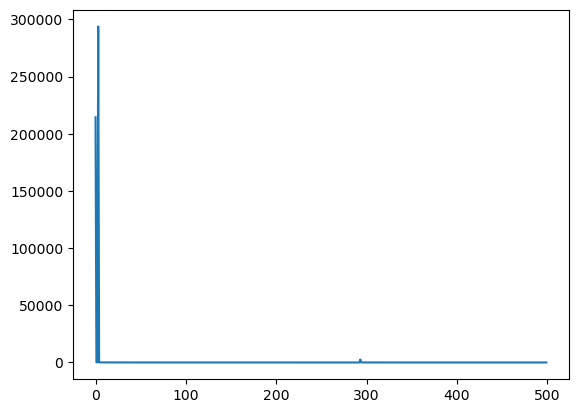

In [43]:
plt.plot(historial.history["loss"])

In [36]:
y_pred = modelo.predict(dfImputadoXNormalizado)


16/16 [==============================] - 0s 1ms/step


In [37]:
y_pred

array([[1.78120518e+01],
       [2.31097484e+00],
       [6.09026527e+01],
       [8.69083862e+01],
       [6.06421165e+01],
       [1.95086842e+01],
       [1.31043930e+01],
       [5.63299599e+01],
       [3.06804543e+01],
       [1.08952653e+00],
       [3.69750690e+00],
       [1.28315287e+01],
       [1.19045544e+01],
       [2.08090954e+01],
       [3.89384174e+00],
       [8.87463689e-01],
       [7.71623898e+00],
       [5.80445099e+00],
       [6.77109528e+00],
       [2.19099188e+00],
       [3.30777383e+00],
       [9.44606781e+00],
       [4.72404266e+02],
       [4.63954437e+02],
       [2.76433163e+01],
       [3.51516876e+02],
       [4.01616240e+00],
       [7.31267700e+01],
       [6.33697701e+00],
       [0.00000000e+00],
       [1.39753256e+01],
       [4.10904350e+01],
       [1.30481949e+01],
       [2.97072773e+01],
       [8.77639580e+00],
       [1.04952593e+01],
       [1.10723763e+01],
       [1.11626406e+01],
       [4.00958939e+01],
       [1.36602697e+01],


In [38]:
marketCapPredicho = ((y_pred / 1000) * float(newMaxMarkCap)) + float(minMarketCap)

In [39]:
dfNormImpCopia = dfImputadoXNormalizado.copy()
dfNormImpCopia.insert(0, 'marketCap', marketCap)
dfNormImpCopia.insert(0, 'marketCapPredNN', marketCapPredicho)
dfNormImpCopia.insert(0, 'symbol', nombres)

In [44]:
show(dfNormImpCopia)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


(array([263., 107.,  39.,  23.,  13.,  14.,   3.,   5.,   3.,   2.,   4.,
          1.,   4.,   1.,   1.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([3.54716928e+09, 3.20400548e+10, 6.05329408e+10, 8.90258309e+10,
        1.17518713e+11, 1.46011603e+11, 1.74504493e+11, 2.02997367e+11,
        2.31490257e+11, 2.59983147e+11, 2.88476037e+11, 3.16968927e+11,
        3.45461817e+11, 3.73954707e+11, 4.02447565e+11, 4.30940455e+11,
        4.59433345e+11, 4.8792

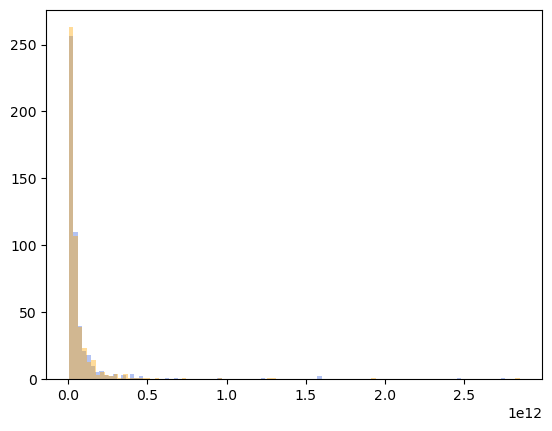

In [41]:
plt.hist(marketCap, bins=100, alpha=0.4, color="royalblue")
plt.hist(marketCapPredicho, bins=100, alpha=0.4, color="orange")

In [42]:
dfNormImpCopia.to_csv('prediccionesMarketCapSinValidarNN.csv') 

In [ ]:
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0, sigma=500, shape=81)

    # model error
    sigma = pm.Exponential("sigma", lam=1/100)

    # matrix-dot products
    m1 = pm.math.matrix_dot(X_train, betas)

    # Likelihood: Normal
    y = pm.Normal("y",
                  mu=m1,
                  sigma=sigma,
                  observed=y_train
                  )

    trace = pm.sample(4000, tune=1000)

C:\Users\fridm\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betas]
